<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [286]:
# !conda install statsmodels seaborn -y

import itertools
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import matplotlib.ticker as ticker
import matplotlib.mlab as mlab

# for using ML models and their scoring\
import sklearn
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, make_scorer, precision_score, recall_score, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# for statistical work
import statsmodels.api as sm
import scipy.stats as st

np.random.seed(42)
%matplotlib inline

# Utility Plotting Functions

In [2]:
def confusion_matrix_plot(y_test, y_pred, labels=(1, 0), figsize=(8, 5)):
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    conf_matrix = pd.DataFrame(
        data=cm, columns=['Predicted:1', 'Predicted:0'], index=['Actual:1', 'Actual:0'])
    plt.figure(figsize=figsize)
    sn.heatmap(conf_matrix, annot=True, fmt='d', cmap="YlGnBu")
    return cm

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [3]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2019-11-25 13:33:19--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22,56K  --.-KB/s    in 0,1s    

2019-11-25 13:33:20 (170 KB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [4]:
df = pd.read_csv('loan_train.csv')
df.head(20)

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male
5,7,7,PAIDOFF,1000,30,9/9/2016,10/8/2016,36,college,male
6,8,8,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,male
7,9,9,PAIDOFF,800,15,9/10/2016,9/24/2016,26,college,male
8,10,10,PAIDOFF,300,7,9/10/2016,9/16/2016,29,college,male
9,11,11,PAIDOFF,1000,15,9/10/2016,10/9/2016,39,High School or Below,male


In [5]:
df.shape

(346, 10)

### Convert to date time object 

In [6]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [12]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [12]:
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


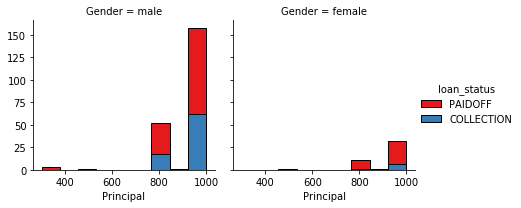

In [27]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
# sns.FacetGrid(
#     dataframe, 
#     col & row, columns and rows for every combination of given fields
#     hue, colors columns with same ratio as values in dataframe
# )
g = (sns.FacetGrid(df, col="Gender",
                  hue="loan_status", 
                  palette="Set1")
    .map(plt.hist, 'Principal', bins=bins, ec="k")
    .add_legend())

plt.show()

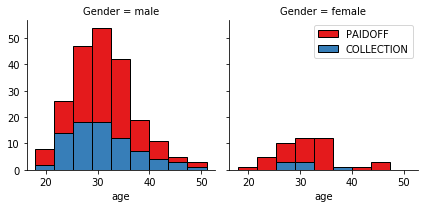

In [28]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender",
                  hue="loan_status",
                  palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

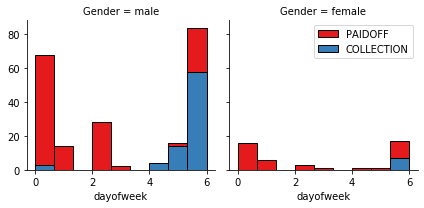

In [29]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [30]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [31]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [32]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [33]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [34]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [35]:

Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [36]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [391]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [400]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# Preprocessing


First we encode the $y$ target variable as an integer, with 0 being "COLLECTION" and 1 being "PAIDOFF"

In [401]:
y = df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], 
                              value=[1,0])
y.head()

0    1
1    1
2    1
3    1
4    1
Name: loan_status, dtype: int64

We use the scikit model_selection package to split data for crossvalidation. 

In [402]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=.2,
                                                    stratify=y,
                                                    random_state=42)

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [403]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, r2_score, confusion_matrix, accuracy_score, f1_score

In [404]:
knn_model = KNeighborsClassifier()

Now we set up parameters for RandomizedSearchCV, that will fine-tune our hyper-parameters. For KNN, the only parameter we care about is number of neighbors.

In [405]:
parameters = {
    "n_neighbors":range(1, 10)
}
RANDOM_STATE = 42
CV = 4
RANDOM_ITERS = 500
SCORING = {
    'f1_score' : make_scorer(f1_score)
}

We use f1 score and crossvalidate on 4 splits.

In [406]:
random_model = RandomizedSearchCV(estimator=knn_model,
                                 random_state=RANDOM_STATE,
                                 param_distributions=parameters,
                                 cv=CV,
                                 scoring='f1',
                                 verbose=True,
                                  n_jobs=-1,
                                  n_iter=RANDOM_ITERS
                                 )

we fit the best knn model.

In [407]:
best_knn_model = random_model.fit(X_train,y_train)

Fitting 4 folds for each of 9 candidates, totalling 36 fits


/home/tornike/.anaconda3/envs/ml_w_py/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 9 is smaller than n_iter=500. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    1.4s finished
/home/tornike/.anaconda3/envs/ml_w_py/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Now we can look at the best number of neighbors for our model, along with best f1 score associated with this number of neighbors.

In [408]:
best_knn_model.best_params_, best_knn_model.best_score_

({'n_neighbors': 7}, 0.8520625509755944)

Let's look at the confusion matrix as well

In [409]:
y_pred = best_knn_model.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[ 5, 12],
       [ 7, 46]])

Now we use all data (except the final test) for training the best selected model.

In [410]:
knn_model = best_knn_model.fit(X,y)

Fitting 4 folds for each of 9 candidates, totalling 36 fits


/home/tornike/.anaconda3/envs/ml_w_py/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 9 is smaller than n_iter=500. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    1.4s finished
/home/tornike/.anaconda3/envs/ml_w_py/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


# Decision Tree

we use same procedure for Decision tree classifier model selection.

In [411]:
from sklearn.tree import DecisionTreeClassifier

In [412]:
model = DecisionTreeClassifier()

In [413]:
parameters = {
    "criterion":["gini", "entropy"],
    "max_depth":range(1,15),
    "max_features":['auto','sqrt','log2',None],
    "class_weight" : ['balanced']
}
RANDOM_STATE = 42
CV = 3
RANDOM_ITERS = 2000

In [414]:
random_tree_model = RandomizedSearchCV(estimator=model,
                                      random_state=RANDOM_STATE,
                                      param_distributions=parameters,
                                      cv=CV,
                                      scoring="f1",
                                      verbose=True,
                                      n_jobs=-1,
                                      n_iter=RANDOM_ITERS)

In [415]:
best_tree_model = random_tree_model.fit(X_train, y_train)

Fitting 3 folds for each of 112 candidates, totalling 336 fits


/home/tornike/.anaconda3/envs/ml_w_py/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 112 is smaller than n_iter=2000. Running 112 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 336 out of 336 | elapsed:    1.9s finished


In [416]:
best_tree_model.best_params_, best_tree_model.best_score_

({'max_features': 'auto',
  'max_depth': 13,
  'criterion': 'entropy',
  'class_weight': 'balanced'},
 0.7905376140117923)

In [417]:
y_pred = best_tree_model.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[ 9,  8],
       [17, 36]])

In [418]:
tree_model = best_tree_model.fit(X,y)

Fitting 3 folds for each of 112 candidates, totalling 336 fits


/home/tornike/.anaconda3/envs/ml_w_py/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 112 is smaller than n_iter=2000. Running 112 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 336 out of 336 | elapsed:    2.2s finished
/home/tornike/.anaconda3/envs/ml_w_py/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


# Support Vector Machine

In [419]:
from sklearn import svm
from scipy import stats as st 

In [420]:
model = svm.SVC(random_state=42)

In [421]:
parameters = {
#     "C":st.expon(scale=100),
    "gamma" : st.expon(scale=.1),
    "kernel":['linear','poly','rbf','sigmoid'],
    "degree": range(2,5),
    "class_weight":['balanced',None]
}
RANDOM_STATE = 42
CV = 3
RANDOM_ITERS = 1000

In [422]:
random_svm_model = RandomizedSearchCV(estimator=model,
                                      random_state=RANDOM_STATE,
                                      param_distributions=parameters,
                                      cv=CV,
                                      scoring="f1",
                                      verbose=True,
                                      n_jobs=-1,
                                      n_iter=RANDOM_ITERS)

In [423]:
best_svm_model = random_svm_model.fit(X_train, y_train)

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 2736 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:    4.7s finished


In [424]:
best_svm_model.best_params_, best_svm_model.best_score_

({'class_weight': None,
  'degree': 4,
  'gamma': 0.06909259562090074,
  'kernel': 'poly'},
 0.8589285714285714)

In [425]:
y_pred = best_svm_model.predict(X_train)
confusion_matrix(y_train, y_pred)

array([[  2,  67],
       [  0, 207]])

In [426]:
svm_model = best_svm_model.fit(X,y)

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 2677 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:    4.3s finished
/home/tornike/.anaconda3/envs/ml_w_py/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


# Logistic Regression

In [427]:
from sklearn.linear_model import LogisticRegression

In [428]:
model = LogisticRegression()

In [429]:
parameters = {
    "C":st.expon.rvs(size=200),
    "solver" : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}
RANDOM_STATE = 42
CV = 3
RANDOM_ITERS = 1000

In [430]:
random_logreg_model = RandomizedSearchCV(estimator=model,
                                      random_state=RANDOM_STATE,
                                      param_distributions=parameters,
                                      cv=CV,
                                      scoring="f1",
                                      verbose=True,
                                      n_jobs=-1,
                                      n_iter=RANDOM_ITERS)

In [431]:
best_logreg_model = random_logreg_model.fit(X_train, y_train)

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 2750 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:    5.1s finished


In [432]:
logreg_model = best_logreg_model.fit(X,y)

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 2750 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:    5.2s finished
/home/tornike/.anaconda3/envs/ml_w_py/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


# Model Evaluation using Test set

In [433]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [434]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2019-11-25 15:39:17--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3,6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3,56K  --.-KB/s    in 0s      

2019-11-25 15:39:17 (174 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [446]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [447]:
test_df.dtypes

Unnamed: 0         int64
Unnamed: 0.1       int64
loan_status       object
Principal          int64
terms              int64
effective_date    object
due_date          object
age                int64
education         object
Gender            object
dtype: object

Process test data as we did with the training data


In [448]:
def process_data(dataframe) -> (X,y):
    df = dataframe.copy()
    df['due_date'] = pd.to_datetime(df['due_date'])
    df['effective_date'] = pd.to_datetime(df['effective_date'])
    df['dayofweek'] = df['effective_date'].dt.dayofweek
    df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
    df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
    df.groupby(['education'])['loan_status'].value_counts(normalize=True)
    Feature = df[['Principal','terms','age','Gender','weekend']]
    Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
    Feature.drop(['Master or Above'], axis = 1,inplace=True)
    X = Feature
    y = df['loan_status'].values
    X = preprocessing.StandardScaler().fit(X).transform(X)
    y = df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], 
                              value=[1,0])
    return X, y

In [469]:
X_test, y_test = process_data(test_df)

In [483]:
# data = [['tom', 10], ['alice', 18]]
# df = pd.DataFrame(data, columns = ['Name', "age"])

# df.head()
models = [knn_model, tree_model, svm_model, logreg_model]

y_hats = [model.predict(X_test) for model in models]

metrics = [jaccard_similarity_score,f1_score,log_loss]

scores = [[metric(y_test, y_hat) for metric in metrics] for y_hat in y_hats]

metrics_names = ["Jaccard", "F1-Score", "LogLoss"]

algo_names = ["KNN", "Decision Tree", "SVM", "LogisticRegression"]
scores
scoring_df = pd.DataFrame(scores, columns=metrics_names)
scoring_df.insert(0, 'Algorithm', algo_names)
scoring_df()

/home/tornike/.anaconda3/envs/ml_w_py/lib/python3.7/site-packages/sklearn/metrics/classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)
/home/tornike/.anaconda3/envs/ml_w_py/lib/python3.7/site-packages/sklearn/metrics/classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)
/home/tornike/.anaconda3/envs/ml_w_py/lib/python3.7/site-packages/sklearn/metrics/classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be 

,Algorithm,Jaccard,F1-Score,LogLoss
0,KNN,0.740741,0.833333,8.954631
1,Decision Tree,0.611111,0.712329,13.431850
2,SVM,0.740741,0.851064,8.954705
3,LogisticRegression,0.740741,0.851064,8.954705


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>